
Processing target: Zinc
Best individual is: [0.45572631798258906, 0.020527968617128467, 0.5444417216952466, 0.31683066037719737, -0.3370168754943358, 0.134776441553344, 0.7922971401254555, 0.9647460802656936, 0.5593230278562127, -0.03610882912182179, 0.4834352720128692, 1.1484181067531465, 0.3361642870307817, 0.14384788142683064, 0.1015159398211363, 0.22344172640243223]
Best R² score is: 0.6091391510813398
Final R² Score for Zinc: 0.6091
Mean Squared Error (MSE) for Zinc: 0.4686
Root Mean Squared Error (RMSE) for Zinc: 0.6845
Mean Absolute Error (MAE) for Zinc: 0.5078


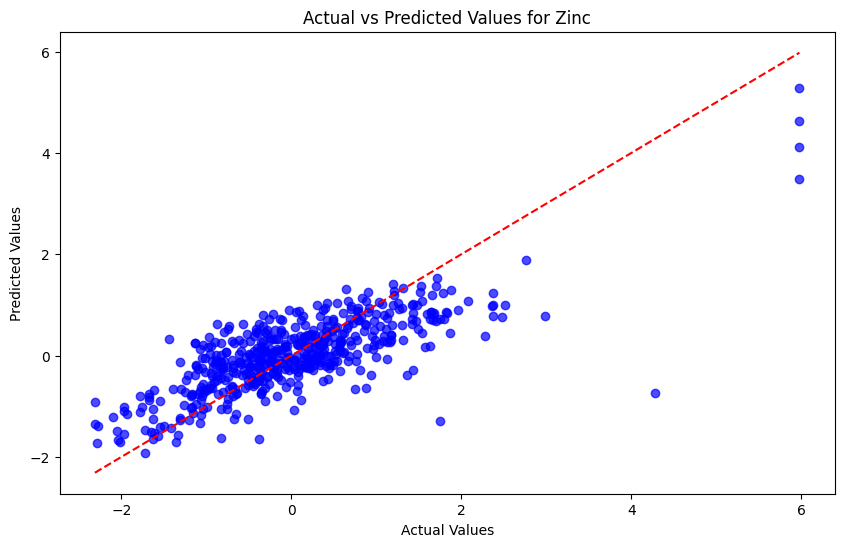


Processing target: Boron


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual is: [0.5948920748123648, 0.16764727252423103, 0.6699243893531741, 0.441027560660033, 0.6557039651660982, -0.3464628860578664, 0.45960028316243795, -0.8754528282739125, 0.05099258231050699, 0.5538174802894107, 0.889082782478702, 0.3625888812910063, -0.19620186020597327, 0.8957154091767306, 0.18525930211400415, 0.5673493841912087]
Best R² score is: 0.7056497412947234
Final R² Score for Boron: 0.7056
Mean Squared Error (MSE) for Boron: 0.3287
Root Mean Squared Error (RMSE) for Boron: 0.5733
Mean Absolute Error (MAE) for Boron: 0.3373


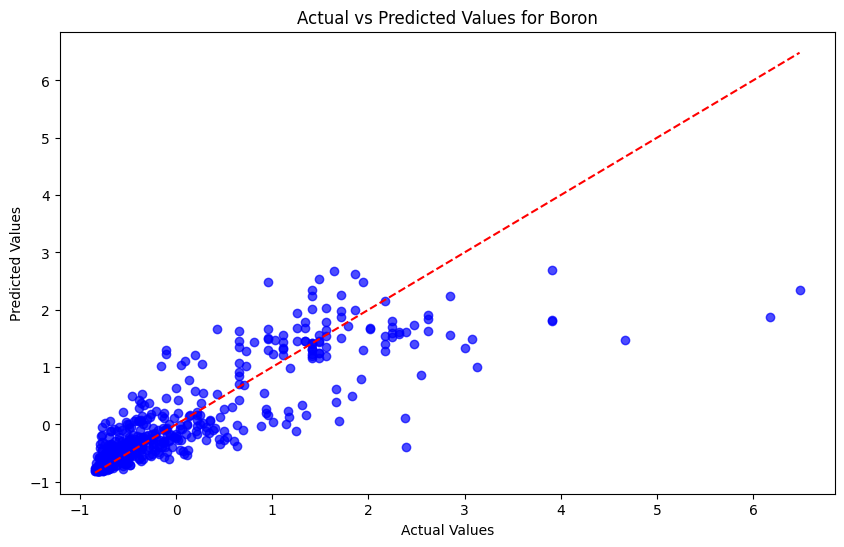


Processing target: SOC


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual is: [0.7643856350345929, -0.15342212911106123, 0.6980884458684522, 0.47532092881903615, 0.7478074350635103, 0.25482058974332855, -0.04976008224197329, -0.2644908479340278, 0.43657211053259215, 0.5058285220976586, 0.47496084410882555, 0.3946140462316204, 0.6073365782860018, -0.28105260195010684, 0.7517873833612448, 0.1394865278715244]
Best R² score is: 0.8060499854883788
Final R² Score for SOC: 0.8060
Mean Squared Error (MSE) for SOC: 0.2164
Root Mean Squared Error (RMSE) for SOC: 0.4652
Mean Absolute Error (MAE) for SOC: 0.2940


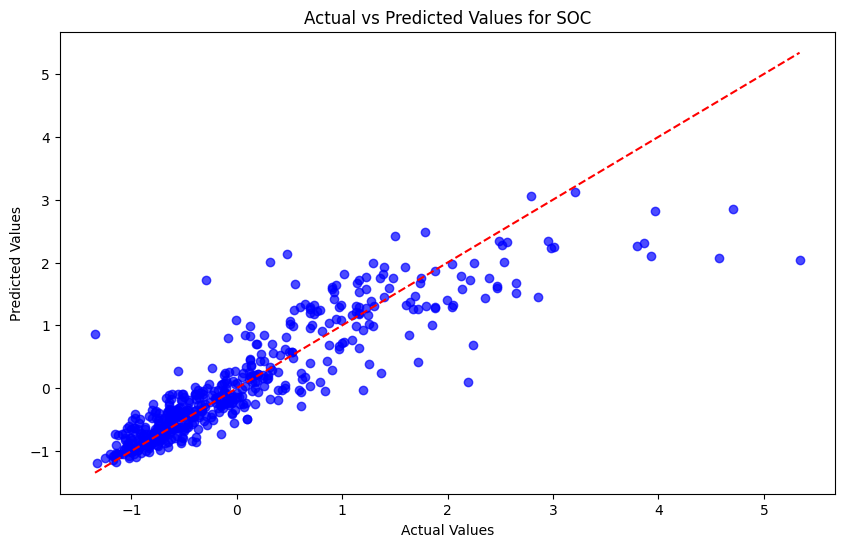

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
file_path = '/kaggle/input/final-ipage/merged_v3.csv'
data = pd.read_csv(file_path)

# Define the list of target variables
targets = ['Zinc', 'Boron', 'SOC']

# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Loop through each target variable
for target in targets:
    print(f"\nProcessing target: {target}")

    # Ensure the target variable is numerical
    if target not in data.columns:
        print(f"Error: {target} is not a valid column in the dataset.")
        continue

    # Remove the target from numerical columns if it exists
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if target in numerical_cols:
        numerical_cols.remove(target)

    # Define features (X) and target (y)
    X = data.drop(columns=[target])
    y = data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # DEAP Genetic Algorithm setup
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_model(individual):
        weights = np.array(individual)
        X_weighted = X_train * weights
        model = RandomForestRegressor(random_state=42)
        model.fit(X_weighted, y_train)
        y_pred = model.predict(X_test * weights)
        return r2_score(y_test, y_pred),

    toolbox.register("evaluate", eval_model)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Run Genetic Algorithm
    population = toolbox.population(n=50)
    NGEN = 10
    CXPB, MUTPB = 0.5, 0.2

    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))

    # Best individual
    best_ind = tools.selBest(population, k=1)[0]
    print("Best individual is:", best_ind)
    print("Best R² score is:", eval_model(best_ind)[0])

    # Model evaluation using the best weights
    best_weights = np.array(best_ind)
    X_weighted_train = X_train * best_weights
    X_weighted_test = X_test * best_weights

    final_model = RandomForestRegressor(random_state=42)
    final_model.fit(X_weighted_train, y_train)
    y_pred = final_model.predict(X_weighted_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Final R² Score for {target}: {r2:.4f}")
    print(f"Mean Squared Error (MSE) for {target}: {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE) for {target}: {rmse:.4f}")
    print(f"Mean Absolute Error (MAE) for {target}: {mae:.4f}")

    # Visualization of predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted Values for {target}")
    plt.show()
